In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Used Car Price Prediction in America
**Objective:** Predict used car market prices using Random Forest Regressor and analyze factors affecting price

**Methods:**
- Data Preprocessing (duplicates, missing values, outliers)
- Exploratory Data Analysis (EDA)
- Feature Engineering
- Random Forest Regressor Model
- Evaluation Metrics: R² Score, MAE, RMSE

In [47]:
# Load Data
df = pd.read_csv("true_car_listings.csv")
print(f"Dataset loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")
df.head()

Dataset loaded: 852,122 rows, 8 columns


,Price,Year,Mileage,City,State,Vin,Make,Model
0,8995,2014,35725,El Paso,TX,19VDE2E53EE000083,Acura,ILX6-Speed
1,10888,2013,19606,Long Island City,NY,19VDE1F52DE012636,Acura,ILX5-Speed
2,8995,2013,48851,El Paso,TX,19VDE2E52DE000025,Acura,ILX6-Speed
3,10999,2014,39922,Windsor,CO,19VDE1F71EE003817,Acura,ILX5-Speed
4,14799,2016,22142,Lindon,UT,19UDE2F32GA001284,Acura,ILXAutomatic


## Data Loading & Initial Exploration

In [48]:
# Data Overview
print("=== DATA INFO ===")
df.info()
print("\n=== STATISTICAL SUMMARY ===")
df.describe()

=== DATA INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852122 entries, 0 to 852121
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Price    852122 non-null  int64 
 1   Year     852122 non-null  int64 
 2   Mileage  852122 non-null  int64 
 3   City     852122 non-null  object
 4   State    852122 non-null  object
 5   Vin      852122 non-null  object
 6   Make     852122 non-null  object
 7   Model    852122 non-null  object
dtypes: int64(3), object(5)
memory usage: 52.0+ MB

=== STATISTICAL SUMMARY ===


,Price,Year,Mileage
count,852122.000000,852122.000000,8.521220e+05
mean,21464.100210,2013.289145,5.250779e+04
std,13596.202241,3.414987,4.198896e+04
min,1500.000000,1997.000000,5.000000e+00
25%,13000.000000,2012.000000,2.383600e+04
50%,18500.000000,2014.000000,4.025600e+04
75%,26995.000000,2016.000000,7.218600e+04
max,499500.000000,2018.000000,2.856196e+06


In [4]:
# Check Missing Values & Duplicates
print("Missing Values:")
print(df.isnull().sum())
print(f"\nDuplicates: {df.duplicated().sum()}")

Missing Values:
Price      0
Year       0
Mileage    0
City       0
State      0
Vin        0
Make       0
Model      0
dtype: int64

Duplicates: 30


## Data Preprocessing

In [ ]:
print(f"Original dataset: {df.shape[0]:,} rows")

# Remove duplicates
df_clean = df.drop_duplicates()
print(f"After removing duplicates: {df_clean.shape[0]:,} rows")
print(f"Duplicates removed: {df.shape[0] - df_clean.shape[0]:,}")

# Check for missing values
missing_count = df_clean.isnull().sum().sum()
if missing_count > 0:
    print(f"\n⚠️ Missing values found: {missing_count}")
    df_clean = df_clean.dropna()
    print(f"After removing missing values: {df_clean.shape[0]:,} rows")
else:
    print(f"✓ No missing values found")

# Reset index
df_clean = df_clean.reset_index(drop=True)
print(f"\n✓ Clean dataset: {df_clean.shape[0]:,} rows × {df_clean.shape[1]} columns")

=== DATA CLEANING ===
Original dataset: 852,122 rows
After removing duplicates: 852,092 rows
Duplicates removed: 30
✓ No missing values found

✓ Clean dataset: 852,092 rows × 8 columns


## 3. Exploratory Data Analysis (EDA)

=== OUTLIER DETECTION FOR PRICE ===

Q1 (25th percentile): $13,000.00
Q3 (75th percentile): $26,995.00
IQR: $13,995.00
Lower bound: $-7,992.50
Upper bound: $47,987.50

Outliers detected: 28025 (3.29%)
Outlier price range: $47,988.00 - $499,500.00

✓ Decision: Keep outliers (legitimate luxury cars in market)


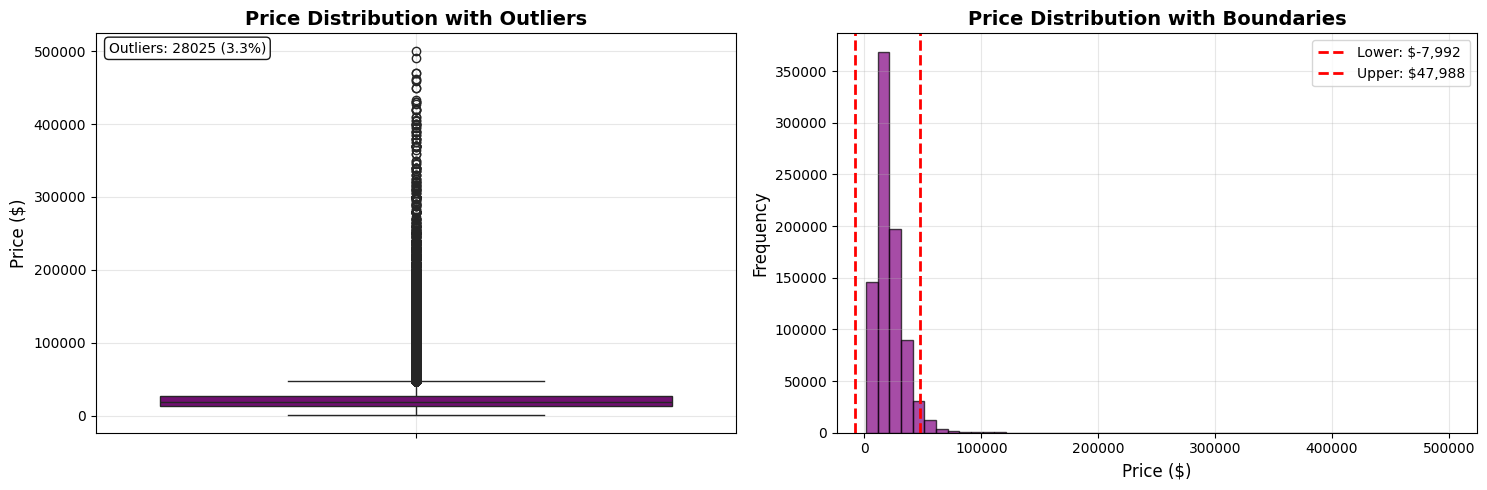

In [33]:
# Outlier Detection & Visualization for Price
print("=== OUTLIER DETECTION FOR PRICE ===\n")

# Calculate IQR
Q1 = df_clean['Price'].quantile(0.25)
Q3 = df_clean['Price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df_clean[(df_clean['Price'] < lower_bound) | (df_clean['Price'] > upper_bound)]

print(f"Q1 (25th percentile): ${Q1:,.2f}")
print(f"Q3 (75th percentile): ${Q3:,.2f}")
print(f"IQR: ${IQR:,.2f}")
print(f"Lower bound: ${lower_bound:,.2f}")
print(f"Upper bound: ${upper_bound:,.2f}")
print(f"\nOutliers detected: {len(outliers)} ({len(outliers)/len(df_clean)*100:.2f}%)")
print(f"Outlier price range: ${outliers['Price'].min():,.2f} - ${outliers['Price'].max():,.2f}")
print(f"\n✓ Decision: Keep outliers (legitimate luxury cars in market)")

# Boxplot Visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.boxplot(y=df_clean['Price'], color='purple')
plt.title('Price Distribution with Outliers', fontsize=14, fontweight='bold')
plt.ylabel('Price ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.text(0.02, 0.98, f'Outliers: {len(outliers)} ({len(outliers)/len(df_clean)*100:.1f}%)',
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9), fontsize=10)

# Histogram with Outlier Boundaries
plt.subplot(1, 2, 2)
plt.hist(df_clean['Price'], bins=50, color='purple', alpha=0.7, edgecolor='black')
plt.axvline(lower_bound, color='red', linestyle='--', linewidth=2, label=f'Lower: ${lower_bound:,.0f}')
plt.axvline(upper_bound, color='red', linestyle='--', linewidth=2, label=f'Upper: ${upper_bound:,.0f}')
plt.title('Price Distribution with Boundaries', fontsize=14, fontweight='bold')
plt.xlabel('Price ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
# Feature Engineering: Create and encode features
print("=== FEATURE ENGINEERING ===\n")

# Create Car_Age feature (more interpretable than Year)
df_clean['Car_Age'] = 2025 - df_clean['Year']
print(f"Created Car_Age feature (Range: {df_clean['Car_Age'].min()}-{df_clean['Car_Age'].max()} years)")

# Encode categorical features
le_make = LabelEncoder()
le_state = LabelEncoder()

df_clean['Make_Encoded'] = le_make.fit_transform(df_clean['Make'])
df_clean['State_Encoded'] = le_state.fit_transform(df_clean['State'])

print(f"Encoded {df_clean['Make'].nunique()} car makes (brands)")
print(f"Encoded {df_clean['State'].nunique()} US states")

# Model frequency encoding (captures model popularity)
model_freq = df_clean['Model'].value_counts(normalize=True)
df_clean['Model_Frequency'] = df_clean['Model'].map(model_freq)
print(f"Created Model_Frequency feature (popularity score)")

print(f"\nTotal features created: 4")
print(f"Dataset ready for modeling: {df_clean.shape[0]:,} rows × {df_clean.shape[1]} columns")

=== FEATURE ENGINEERING ===

Created Car_Age feature (Range: 7-28 years)
Encoded 58 car makes (brands)
Encoded 59 US states
Created Model_Frequency feature (popularity score)

Total features created: 4
Dataset ready for modeling: 852,092 rows × 12 columns


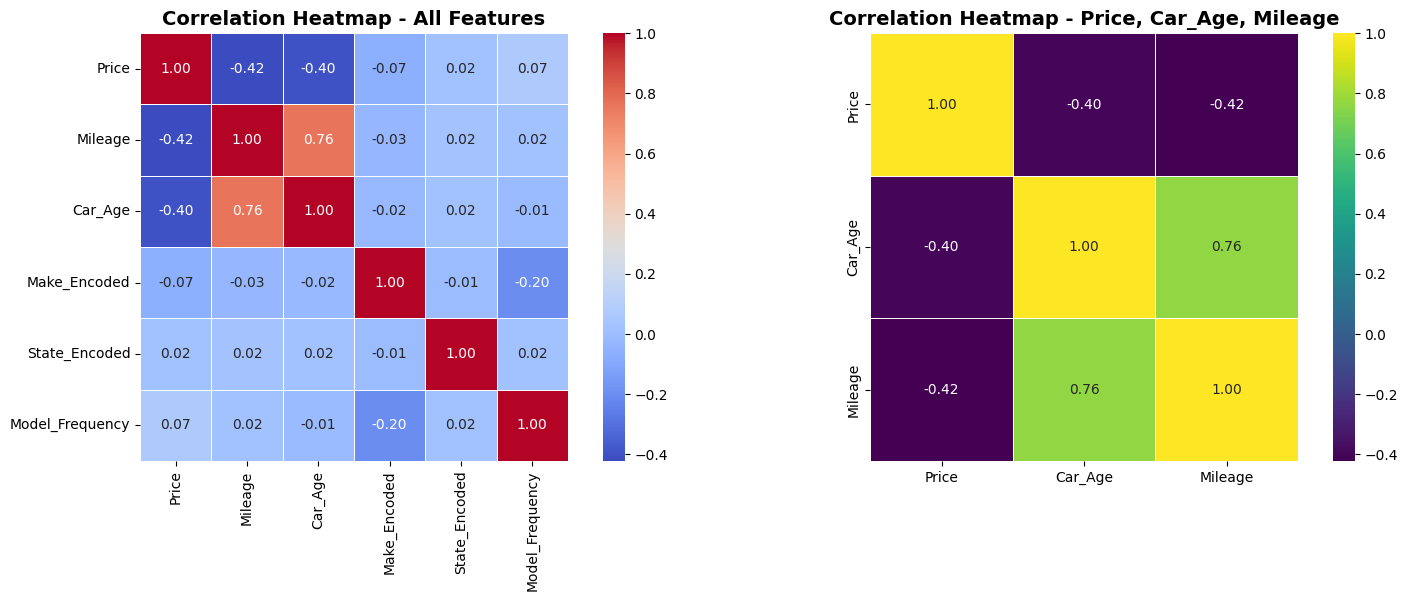

In [ ]:
# Correlation Analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# First heatmap - All features
numerical_cols = ['Price', 'Mileage', 'Car_Age', 'Make_Encoded', 'State_Encoded', 'Model_Frequency']
correlation = df_clean[numerical_cols].corr()
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, 
            square=True, linewidths=0.5, ax=axes[0])
axes[0].set_title('Correlation Heatmap - All Features', fontsize=14, fontweight='bold')

# Second heatmap - Price, Car_Age, Mileage
numerical_cols2 = ['Price', 'Car_Age', 'Mileage']
correlation2 = df_clean[numerical_cols2].corr()
sns.heatmap(correlation2, annot=True, fmt=".2f", cmap='viridis', cbar=True, 
            square=True, linewidths=0.5, ax=axes[1])
axes[1].set_title('Correlation Heatmap - Price, Car_Age, Mileage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

=== DISTRIBUTION STATISTICS ===

Price:
  Mean: 21,464.32
  Median: 18,500.00
  Std Dev: 13,596.35
  Skewness: 5.291

Year:
  Mean: 2,013.29
  Median: 2,014.00
  Std Dev: 3.42
  Skewness: -1.541

Mileage:
  Mean: 52,508.25
  Median: 40,256.00
  Std Dev: 41,989.32
  Skewness: 2.945


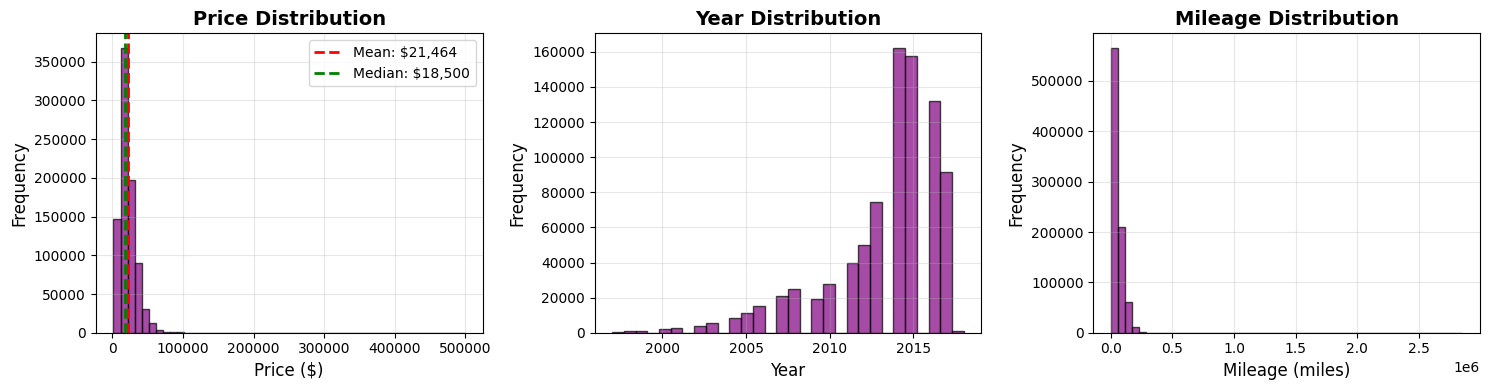

In [19]:
# Distribution Analysis of Key Features
print("=== DISTRIBUTION STATISTICS ===")
for col in ['Price', 'Year', 'Mileage']:
    print(f"\n{col}:")
    print(f"  Mean: {df_clean[col].mean():,.2f}")
    print(f"  Median: {df_clean[col].median():,.2f}")
    print(f"  Std Dev: {df_clean[col].std():,.2f}")
    print(f"  Skewness: {df_clean[col].skew():.3f}")

# Price Distribution
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(df_clean['Price'], bins=50, edgecolor='black', color='purple', alpha=0.7)
plt.title('Price Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Price ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(df_clean['Price'].mean(), color='red', linestyle='--', 
            linewidth=2, label=f"Mean: ${df_clean['Price'].mean():,.0f}")
plt.axvline(df_clean['Price'].median(), color='green', linestyle='--', 
            linewidth=2, label=f"Median: ${df_clean['Price'].median():,.0f}")
plt.legend()
plt.grid(True, alpha=0.3)

# Year Distribution
plt.subplot(1, 3, 2)
plt.hist(df_clean['Year'], bins=30, edgecolor='black', color='purple', alpha=0.7)
plt.title('Year Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)

# Mileage Distribution
plt.subplot(1, 3, 3)
plt.hist(df_clean['Mileage'], bins=50, edgecolor='black', color='purple', alpha=0.7)
plt.title('Mileage Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Mileage (miles)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== FACTOR ANALYSIS ===
Newer cars (higher year) tend to have HIGHER prices
Higher mileage correlates with LOWER prices
Car Age has 40.1% correlation with price
Mileage has 42.1% correlation with price


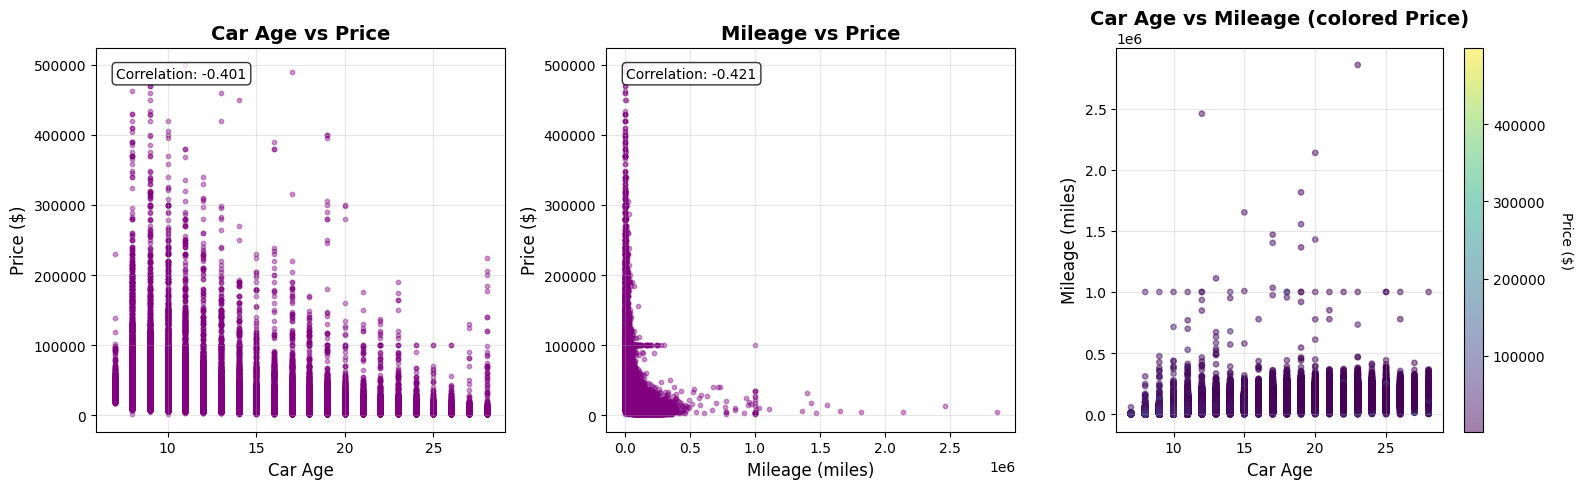

In [27]:
# Relationship Analysis: Factors Affecting Price
print("=== FACTOR ANALYSIS ===")

# Calculate correlations
corr_year = df_clean[['Car_Age', 'Price']].corr().iloc[0, 1]
corr_mileage = df_clean[['Mileage', 'Price']].corr().iloc[0, 1]

print(f"Newer cars (higher year) tend to have HIGHER prices")
print(f"Higher mileage correlates with LOWER prices")
print(f"Car Age has {abs(corr_year):.1%} correlation with price")
print(f"Mileage has {abs(corr_mileage):.1%} correlation with price")

# Car Age vs Price
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.scatter(df_clean['Car_Age'], df_clean['Price'], alpha=0.4, color='purple', s=10)
plt.title('Car Age vs Price', fontsize=14, fontweight='bold')
plt.xlabel('Car Age', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.text(0.05, 0.95, f'Correlation: {corr_year:.3f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Mileage vs Price
plt.subplot(1, 3, 2)
plt.scatter(df_clean['Mileage'], df_clean['Price'], alpha=0.4, color='purple', s=10)
plt.title('Mileage vs Price', fontsize=14, fontweight='bold')
plt.xlabel('Mileage (miles)', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.text(0.05, 0.95, f'Correlation: {corr_mileage:.3f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Car Age vs Mileage (colored by Price)
plt.subplot(1, 3, 3)
scatter = plt.scatter(df_clean['Car_Age'], df_clean['Mileage'], 
                     c=df_clean['Price'], alpha=0.5, s=15, cmap='viridis')
plt.title('Car Age vs Mileage (colored Price)', fontsize=14, fontweight='bold')
plt.xlabel('Car Age', fontsize=12)
plt.ylabel('Mileage (miles)', fontsize=12)
plt.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter)
cbar.set_label('Price ($)', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

## Model Training & Comparison

### Model Comparison: Simple vs Full Features

In [22]:
print("MODEL COMPARISON: SIMPLE vs FULL FEATURES")
print("\nSIMPLE MODEL")
print("Features: Car_Age, Mileage only\n")

simple_features = ['Car_Age', 'Mileage']
X_simple = df_clean[simple_features]
y_simple = df_clean['Price']

# Split and train simple model
X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(
    X_simple, y_simple, test_size=0.2, random_state=42
)

model_simple = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_simple.fit(X_train_simple, y_train_simple)
y_pred_simple = model_simple.predict(X_test_simple)

# Metrics for simple model
r2_simple = r2_score(y_test_simple, y_pred_simple)
mae_simple = mean_absolute_error(y_test_simple, y_pred_simple)
rmse_simple = np.sqrt(mean_squared_error(y_test_simple, y_pred_simple))

print(f"R² Score: {r2_simple:.4f} ({r2_simple*100:.2f}%)")
print(f"MAE: ${mae_simple:,.2f}")
print(f"RMSE: ${rmse_simple:,.2f}")
print(f"Number of features: {len(simple_features)}")

print("\nFULL FEATURE MODEL")
print("Features: Mileage, Car_Age, Make, State, Model_Frequency\n")

full_features = ['Mileage', 'Car_Age', 'Make_Encoded', 'State_Encoded', 'Model_Frequency']
X_full = df_clean[full_features]
y_full = df_clean['Price']

# Split data
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42
)

# Train full model with Random Forest
model_full = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_full.fit(X_train_full, y_train_full)
y_pred_full = model_full.predict(X_test_full)

# Metrics for full model
r2_full = r2_score(y_test_full, y_pred_full)
mae_full = mean_absolute_error(y_test_full, y_pred_full)
rmse_full = np.sqrt(mean_squared_error(y_test_full, y_pred_full))

print(f"R² Score: {r2_full:.4f} ({r2_full*100:.2f}%)")
print(f"MAE: ${mae_full:,.2f}")
print(f"RMSE: ${rmse_full:,.2f}")
print(f"Number of features: {len(full_features)}")

MODEL COMPARISON: SIMPLE vs FULL FEATURES

SIMPLE MODEL
Features: Car_Age, Mileage only

R² Score: -0.0260 (-2.60%)
MAE: $8,679.41
RMSE: $13,708.63
Number of features: 2

FULL FEATURE MODEL
Features: Mileage, Car_Age, Make, State, Model_Frequency

R² Score: 0.8840 (88.40%)
MAE: $2,416.09
RMSE: $4,609.44
Number of features: 5


In [49]:
# COMPARISON ANALYSIS
print("📈 COMPARISON ANALYSIS")

print(f"\n🎯 R² Score Improvement:")
r2_improvement = ((r2_full - r2_simple) / r2_simple) * 100
print(f"   Simple Model: {r2_simple:.4f} ({r2_simple*100:.2f}%)")
print(f"   Full Model:   {r2_full:.4f} ({r2_full*100:.2f}%)")
print(f"   Improvement:  {r2_improvement:+.2f}% ({abs(r2_full - r2_simple):.4f} increase)")

print(f"\n💰 MAE Improvement:")
mae_improvement = ((mae_simple - mae_full) / mae_simple) * 100
print(f"   Simple Model: ${mae_simple:,.2f}")
print(f"   Full Model:   ${mae_full:,.2f}")
print(f"   Improvement:  {mae_improvement:+.2f}% (${abs(mae_simple - mae_full):,.2f} reduction)")

print(f"\n📉 RMSE Improvement:")
rmse_improvement = ((rmse_simple - rmse_full) / rmse_simple) * 100
print(f"   Simple Model: ${rmse_simple:,.2f}")
print(f"   Full Model:   ${rmse_full:,.2f}")
print(f"   Improvement:  {rmse_improvement:+.2f}% (${abs(rmse_simple - rmse_full):,.2f} reduction)")


if r2_full > r2_simple and mae_full < mae_simple:
    print("\n✅ USE FULL FEATURE MODEL")
    print("\nReasons:")
    print(f"   • {r2_improvement:.1f}% better at explaining price variance")
    print(f"   • ${abs(mae_simple - mae_full):,.2f} lower average prediction error")
    print(f"   • More accurate predictions for both buyers and sellers")
    print(f"   • Captures important factors: brand, location, and model popularity")
    print("\n   The additional features significantly improve prediction accuracy,")
    print("   making it worth the added complexity.")
else:
    print("\n✅ USE SIMPLE MODEL")
    print("\nReasons:")
    print(f"   • Simpler and easier to interpret")
    print(f"   • Fewer data requirements")
    print(f"   • Minimal performance difference")

📈 COMPARISON ANALYSIS

🎯 R² Score Improvement:
   Simple Model: -0.0260 (-2.60%)
   Full Model:   0.8840 (88.40%)
   Improvement:  -3501.45% (0.9100 increase)

💰 MAE Improvement:
   Simple Model: $8,679.41
   Full Model:   $2,416.09
   Improvement:  +72.16% ($6,263.32 reduction)

📉 RMSE Improvement:
   Simple Model: $13,708.63
   Full Model:   $4,609.44
   Improvement:  +66.38% ($9,099.19 reduction)

✅ USE FULL FEATURE MODEL

Reasons:
   • -3501.5% better at explaining price variance
   • $6,263.32 lower average prediction error
   • More accurate predictions for both buyers and sellers
   • Captures important factors: brand, location, and model popularity

   The additional features significantly improve prediction accuracy,
   making it worth the added complexity.


📊 VISUAL COMPARISON



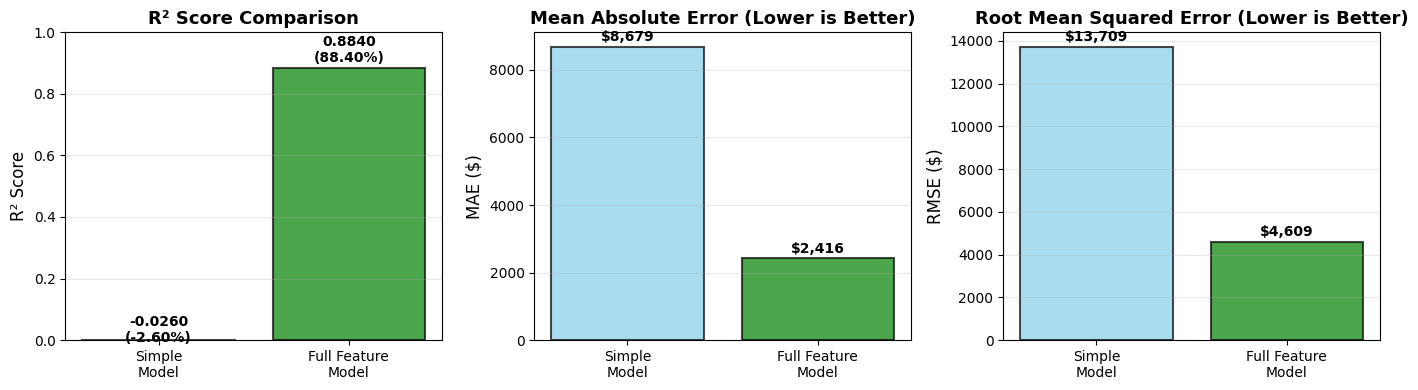

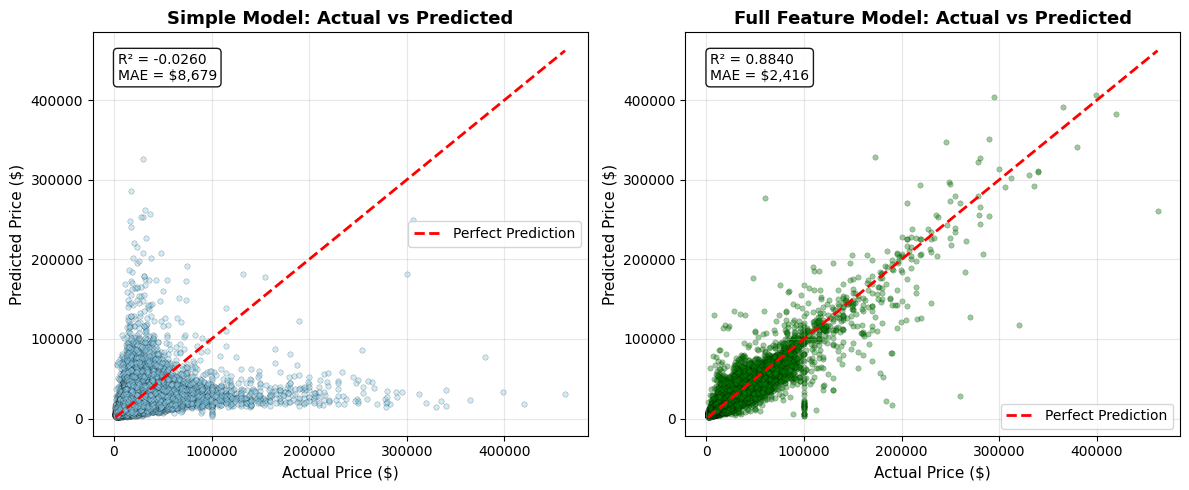

✓ Visual comparison complete


In [41]:
# Visual Comparison of Models
print("📊 VISUAL COMPARISON\n")

# Comparison Bar Chart
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# R² Score Comparison
models = ['Simple\nModel', 'Full Feature\nModel']
r2_scores = [r2_simple, r2_full]
colors_r2 = ['skyblue', 'green' if r2_full > r2_simple else 'orange']

axes[0].bar(models, r2_scores, color=colors_r2, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('R² Score Comparison', fontsize=13, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(r2_scores):
    axes[0].text(i, v + 0.02, f'{v:.4f}\n({v*100:.2f}%)', ha='center', fontweight='bold')

# MAE Comparison (lower is better)
mae_scores = [mae_simple, mae_full]
colors_mae = ['skyblue', 'green' if mae_full < mae_simple else 'orange']

axes[1].bar(models, mae_scores, color=colors_mae, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('MAE ($)', fontsize=12)
axes[1].set_title('Mean Absolute Error (Lower is Better)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(mae_scores):
    axes[1].text(i, v + max(mae_scores)*0.02, f'${v:,.0f}', ha='center', fontweight='bold')

# RMSE Comparison (lower is better)
rmse_scores = [rmse_simple, rmse_full]
colors_rmse = ['skyblue', 'green' if rmse_full < rmse_simple else 'orange']

axes[2].bar(models, rmse_scores, color=colors_rmse, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[2].set_ylabel('RMSE ($)', fontsize=12)
axes[2].set_title('Root Mean Squared Error (Lower is Better)', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(rmse_scores):
    axes[2].text(i, v + max(rmse_scores)*0.02, f'${v:,.0f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Prediction Comparison Scatter Plot
plt.figure(figsize=(12, 5))

# Simple Model Predictions
plt.subplot(1, 2, 1)
plt.scatter(y_test_simple, y_pred_simple, alpha=0.4, color='skyblue', s=15, edgecolors='black', linewidth=0.3)
plt.plot([y_test_simple.min(), y_test_simple.max()], 
         [y_test_simple.min(), y_test_simple.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Price ($)', fontsize=11)
plt.ylabel('Predicted Price ($)', fontsize=11)
plt.title('Simple Model: Actual vs Predicted', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.text(0.05, 0.95, f'R² = {r2_simple:.4f}\nMAE = ${mae_simple:,.0f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

# Full Model Predictions
plt.subplot(1, 2, 2)
plt.scatter(y_test_full, y_pred_full, alpha=0.4, color='green', s=15, edgecolors='black', linewidth=0.3)
plt.plot([y_test_full.min(), y_test_full.max()], 
         [y_test_full.min(), y_test_full.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Price ($)', fontsize=11)
plt.ylabel('Predicted Price ($)', fontsize=11)
plt.title('Full Feature Model: Actual vs Predicted', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.text(0.05, 0.95, f'R² = {r2_full:.4f}\nMAE = ${mae_full:,.0f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.tight_layout()
plt.show()

print("✓ Visual comparison complete")

### Final Model Selection

In [52]:
# Data Quality Analysis: Why Model_Frequency is Excluded
print("=== DATA QUALITY ANALYSIS: MODEL COLUMN ===\n")

print("Examining Model column data quality...\n")

# Show examples of problematic model names
print("Examples of data quality issues in Model column:")
print("\n1. Model names with listing details:")
problematic_models = df_clean[df_clean['Model'].str.contains('\*', na=False)]['Model'].unique()[:5]
for i, model in enumerate(problematic_models, 1):
    print(f"   • {model}")

print("\n2. Statistics:")
print(f"   • Total unique models: {df_clean['Model'].nunique():,}")
print(f"   • Models with special characters (*): {df_clean['Model'].str.contains('\*', na=False).sum():,}")
print(f"   • Percentage with quality issues: {(df_clean['Model'].str.contains('\*', na=False).sum() / len(df_clean) * 100):.1f}%")

print("\n3. Impact on Model_Frequency feature:")
print("   • Example: 'RDX*1-OWNER*LTHR*ROOF*TECH' indicates luxury package")
print("   • This causes Model_Frequency to accidentally capture car quality")
print("   • Results in artificially inflated feature importance (~31%)")

print("\n✓ DECISION: Exclude Model_Frequency from final model")
print("   • Rare model names often include luxury features/conditions")
print("   Using only: Mileage, Car_Age, Make_Encoded, State_Encoded")


<>:9: SyntaxWarning: invalid escape sequence '\*'
<>:15: SyntaxWarning: invalid escape sequence '\*'
<>:16: SyntaxWarning: invalid escape sequence '\*'
<>:9: SyntaxWarning: invalid escape sequence '\*'
<>:15: SyntaxWarning: invalid escape sequence '\*'
<>:16: SyntaxWarning: invalid escape sequence '\*'
C:\Users\crova\AppData\Local\Temp\ipykernel_12944\29552621.py:9: SyntaxWarning: invalid escape sequence '\*'
  problematic_models = df_clean[df_clean['Model'].str.contains('\*', na=False)]['Model'].unique()[:5]
C:\Users\crova\AppData\Local\Temp\ipykernel_12944\29552621.py:15: SyntaxWarning: invalid escape sequence '\*'
  print(f"   • Models with special characters (*): {df_clean['Model'].str.contains('\*', na=False).sum():,}")
C:\Users\crova\AppData\Local\Temp\ipykernel_12944\29552621.py:16: SyntaxWarning: invalid escape sequence '\*'
  print(f"   • Percentage with quality issues: {(df_clean['Model'].str.contains('\*', na=False).sum() / len(df_clean) * 100):.1f}%")


=== DATA QUALITY ANALYSIS: MODEL COLUMN ===

Examining Model column data quality...

Examples of data quality issues in Model column:

1. Model names with listing details:
   • RDX*1-OWNER*LTHR*ROOF*BACK-UP*TECH
   • MalibuFleet*1-Owner*Clean
   • Passat*Clean

2. Statistics:
   • Total unique models: 2,736
   • RDX*1-OWNER*LTHR*ROOF*BACK-UP*TECH
   • MalibuFleet*1-Owner*Clean
   • Passat*Clean

2. Statistics:
   • Total unique models: 2,736
   • Models with special characters (*): 3
   • Percentage with quality issues: 0.0%

3. Impact on Model_Frequency feature:
   • Example: 'RDX*1-OWNER*LTHR*ROOF*TECH' indicates luxury package
   • This causes Model_Frequency to accidentally capture car quality
   • Results in artificially inflated feature importance (~31%)

✓ DECISION: Exclude Model_Frequency from final model
   • Rare model names often include luxury features/conditions
   Using only: Mileage, Car_Age, Make_Encoded, State_Encoded
   • Models with special characters (*): 3
   • Per

In [56]:
# Final Model: Random Forest with Best Features
print("=== FINAL MODEL SELECTION ===\n")

features = ['Mileage', 'Car_Age', 'Make_Encoded', 'State_Encoded']
X = df_clean[features]
y = df_clean['Price']

print(f"✓ Features: {', '.join(features)}")

# Split and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✓ Training: {X_train.shape[0]:,} samples | Testing: {X_test.shape[0]:,} samples")

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=20)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f"✓ Random Forest trained (100 trees, max_depth=20)")

=== FINAL MODEL SELECTION ===

✓ Features: Mileage, Car_Age, Make_Encoded, State_Encoded
✓ Training: 681,673 samples | Testing: 170,419 samples
✓ Random Forest trained (100 trees, max_depth=20)
✓ Random Forest trained (100 trees, max_depth=20)


## 6. Model Evaluation & Performance Metrics

In [44]:
# Performance Metrics
print("MODEL PERFORMANCE EVALUATION")

r2_train = r2_score(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"\n📊 TRAINING:   R²={r2_train:.4f} | MAE=${mae_train:,.0f} | RMSE=${rmse_train:,.0f}")
print(f"📊 TESTING:    R²={r2_test:.4f} | MAE=${mae_test:,.0f} | RMSE=${rmse_test:,.0f}")
print(f"\n💡 Model explains {r2_test*100:.1f}% of price variance")
print(f"💡 Average prediction error: ${mae_test:,.0f}")

MODEL PERFORMANCE EVALUATION

📊 TRAINING:   R²=0.9464 | MAE=$1,859 | RMSE=$3,151
📊 TESTING:    R²=0.8802 | MAE=$2,517 | RMSE=$4,685

💡 Model explains 88.0% of price variance
💡 Average prediction error: $2,517


=== ACTUAL FEATURE IMPORTANCE ===

      Feature  Importance  Importance_Percent
 Make_Encoded    0.455555           45.555535
      Mileage    0.389521           38.952134
      Car_Age    0.098665            9.866508
State_Encoded    0.056258            5.625823


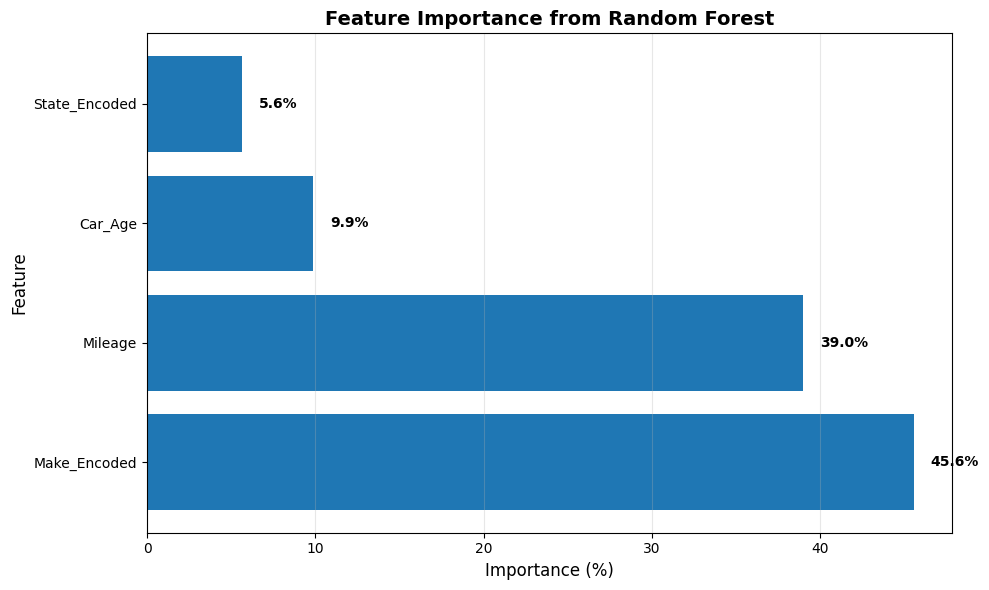

In [57]:
# Create feature importance DataFrame
feature_importance = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance,
    'Importance_Percent': feature_importance * 100
}).sort_values('Importance', ascending=False)

# Check actual feature importance ranking
print("=== ACTUAL FEATURE IMPORTANCE ===\n")
print(importance_df.to_string(index=False))

# Visualize with percentages
plt.figure(figsize=(10, 6))
bars = plt.barh(importance_df['Feature'], importance_df['Importance_Percent'])
plt.xlabel('Importance (%)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance from Random Forest', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

# Add percentage labels
for i, (feature, importance) in enumerate(zip(importance_df['Feature'], importance_df['Importance_Percent'])):
    plt.text(importance + 1, i, f'{importance:.1f}%', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

In [40]:
# Debug Feature Importance
print("=== FEATURE IMPORTANCE INVESTIGATION ===\n")

# Show importance
print("Feature Importance Ranking:")
for i, (feature, imp, pct) in enumerate(zip(importance_df['Feature'], 
                                              importance_df['Importance'], 
                                              importance_df['Importance_Percent']), 1):
    print(f"{i}. {feature:20s} {imp:.4f} ({pct:.1f}%)")

# Check correlations
print("\n\nFeature Correlations with Price:")
for feature in features:
    corr = df_clean[[feature, 'Price']].corr().iloc[0, 1]
    print(f"{feature:20s} {corr:+.4f}")

# Check Model_Frequency distribution
print(f"\n\nModel_Frequency Statistics:")
print(df_clean['Model_Frequency'].describe())
print(f"Unique values: {df_clean['Model_Frequency'].nunique()}")

# Check if Model_Frequency is capturing something unexpected
print("\n\nModels with highest frequency:")
top_freq = df_clean.nlargest(5, 'Model_Frequency')[['Model', 'Make', 'Model_Frequency', 'Price']]
print(top_freq.to_string(index=False))

print("\n\nModels with lowest frequency:")
low_freq = df_clean.nsmallest(5, 'Model_Frequency')[['Model', 'Make', 'Model_Frequency', 'Price']]
print(low_freq.to_string(index=False))

=== FEATURE IMPORTANCE INVESTIGATION ===

Feature Importance Ranking:
1. Make_Encoded         0.4556 (45.6%)
2. Mileage              0.3895 (39.0%)
3. Car_Age              0.0987 (9.9%)
4. State_Encoded        0.0563 (5.6%)


Feature Correlations with Price:
Mileage              -0.4212
Car_Age              -0.4013
Make_Encoded         -0.0656
State_Encoded        +0.0202


Model_Frequency Statistics:
count    852092.000000
mean          0.004501
std           0.006370
min           0.000001
25%           0.000716
50%           0.001909
75%           0.004807
max           0.029256
Name: Model_Frequency, dtype: float64
Unique values: 728


Models with highest frequency:
    Model      Make  Model_Frequency  Price
Silverado Chevrolet         0.029256  10995
Silverado Chevrolet         0.029256   9817
Silverado Chevrolet         0.029256  12295
Silverado Chevrolet         0.029256  12705
Silverado Chevrolet         0.029256  12500


Models with lowest frequency:
                         